# **Problem Statement:**
This internship project focuses on leveraging machine learning classification techniques to develop an
effective fraud detection system for Fastag transactions. The dataset comprises key features such as
transaction details, vehicle information, geographical location, and transaction amounts. The goal is to
create a robust model that can accurately identify instances of fraudulent activity, ensuring the integrity
and security of Fastag transactions.


# Data exploration


In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc


In [227]:
df=pd.read_csv("/content/FastagFraudDetection.csv")

In [228]:
df.shape

(5000, 13)

In [229]:
df.head(2)

,Transaction_ID,Timestamp,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator
0,1,1/6/2023 11:20,Bus,FTG-001-ABC-121,A-101,Express,Large,350,120,"13.059816123454882, 77.77068662374292",65,KA11AB1234,Fraud
1,2,1/7/2023 14:55,Car,FTG-002-XYZ-451,B-102,Regular,Small,120,100,"13.059816123454882, 77.77068662374292",78,KA66CD5678,Fraud


In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Transaction_ID         5000 non-null   int64 
 1   Timestamp              5000 non-null   object
 2   Vehicle_Type           5000 non-null   object
 3   FastagID               4451 non-null   object
 4   TollBoothID            5000 non-null   object
 5   Lane_Type              5000 non-null   object
 6   Vehicle_Dimensions     5000 non-null   object
 7   Transaction_Amount     5000 non-null   int64 
 8   Amount_paid            5000 non-null   int64 
 9   Geographical_Location  5000 non-null   object
 10  Vehicle_Speed          5000 non-null   int64 
 11  Vehicle_Plate_Number   5000 non-null   object
 12  Fraud_indicator        5000 non-null   object
dtypes: int64(4), object(9)
memory usage: 507.9+ KB


In [231]:
df.isna().sum()

Transaction_ID             0
Timestamp                  0
Vehicle_Type               0
FastagID                 549
TollBoothID                0
Lane_Type                  0
Vehicle_Dimensions         0
Transaction_Amount         0
Amount_paid                0
Geographical_Location      0
Vehicle_Speed              0
Vehicle_Plate_Number       0
Fraud_indicator            0
dtype: int64

In [232]:
df.dropna(inplace=True)
df.isna().sum()

Transaction_ID           0
Timestamp                0
Vehicle_Type             0
FastagID                 0
TollBoothID              0
Lane_Type                0
Vehicle_Dimensions       0
Transaction_Amount       0
Amount_paid              0
Geographical_Location    0
Vehicle_Speed            0
Vehicle_Plate_Number     0
Fraud_indicator          0
dtype: int64

In [233]:
df.describe()

,Transaction_ID,Transaction_Amount,Amount_paid,Vehicle_Speed
count,4451.000000,4451.000000,4451.000000,4451.000000
mean,2466.227140,180.927881,158.684565,67.884745
std,1428.941144,103.004437,99.857565,16.632295
min,1.000000,0.000000,0.000000,10.000000
25%,1254.500000,110.000000,100.000000,55.000000
50%,2405.000000,140.000000,120.000000,67.000000
75%,3702.500000,300.000000,180.000000,82.000000
max,5000.000000,350.000000,350.000000,118.000000


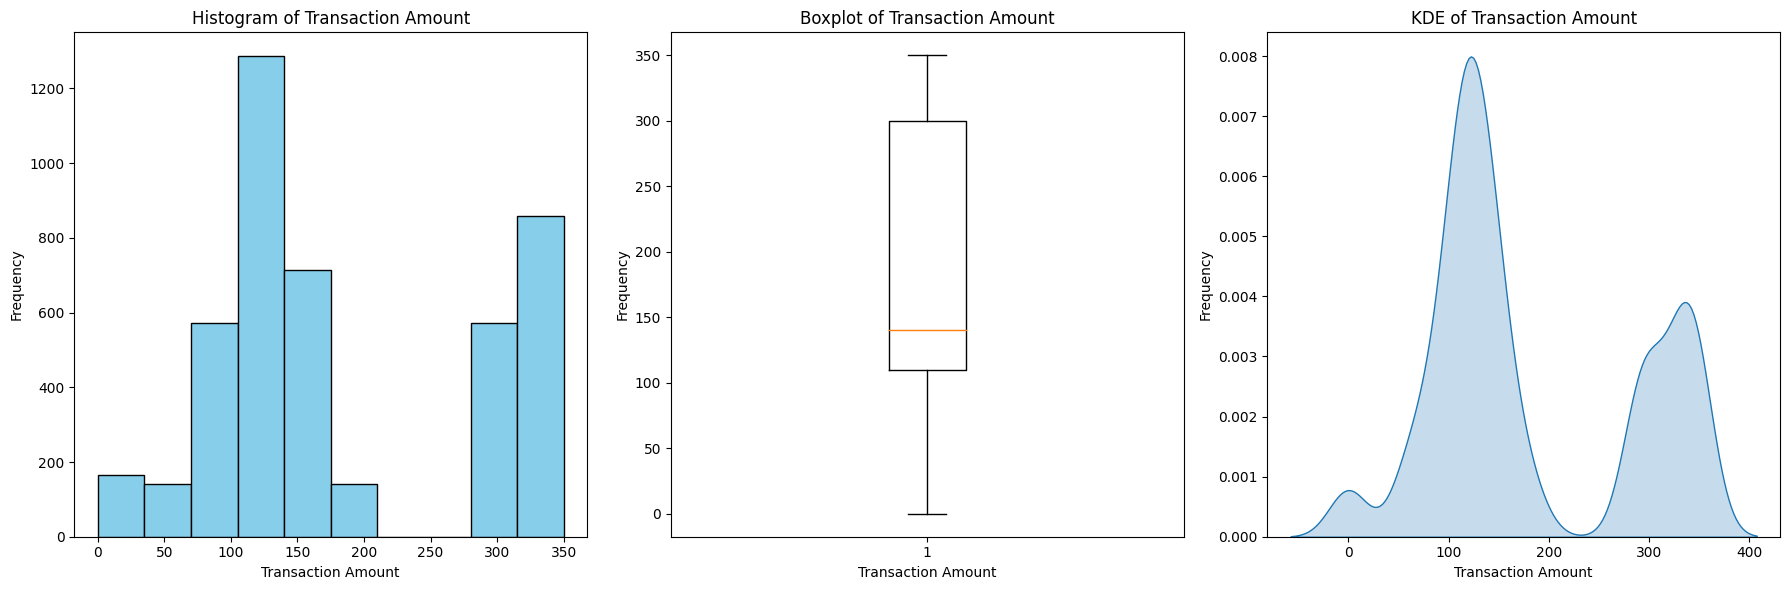

In [234]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.hist(df['Transaction_Amount'],bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Transaction Amount')

plt.subplot(1,3,2)
plt.boxplot(df['Transaction_Amount'])
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Boxplot of Transaction Amount')

plt.subplot(1,3,3)
sns.kdeplot(df['Transaction_Amount'],fill=True)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('KDE of Transaction Amount')

plt.tight_layout()
plt.show()



There is no outliers but the bimodal shape might be because of relation with other features, let's explore!

# Average transaction amount by vehicle type

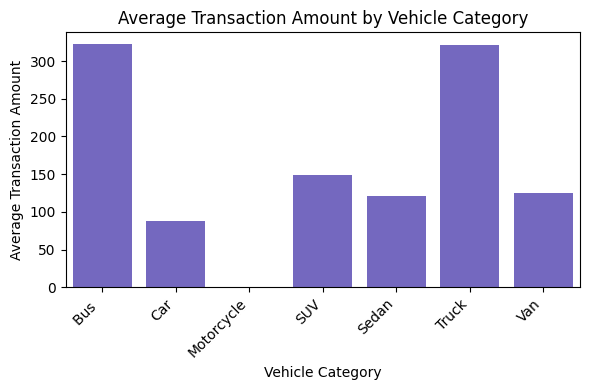

In [235]:

avg_transaction_amounts = df.groupby('Vehicle_Type')['Transaction_Amount'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='Vehicle_Type', y='Transaction_Amount', data=avg_transaction_amounts, color='#6A5ACD')
plt.xlabel('Vehicle Category')
plt.ylabel('Average Transaction Amount')
plt.title('Average Transaction Amount by Vehicle Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Interpretation:

**Commercial vs. Personal Usage:**
Buses and trucks are often used for commercial purposes, such as transporting goods or passengers, while cars and motorcycles are typically used for personal transportation. The higher transaction amounts for buses and trucks could indicate increased toll charges for commercial vehicles compared to personal vehicles.

# Distribution of fraudulent transactions

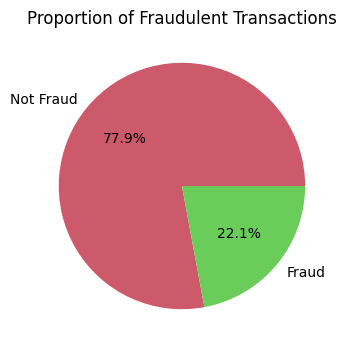

In [236]:

plt.figure(figsize=(6,4))
df['Fraud_indicator'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#CD5A6A', '#6ACD5A'])
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.show()




Data is **imbalanced**

# KDE plot for both Transaction_Amount and Amount_paid

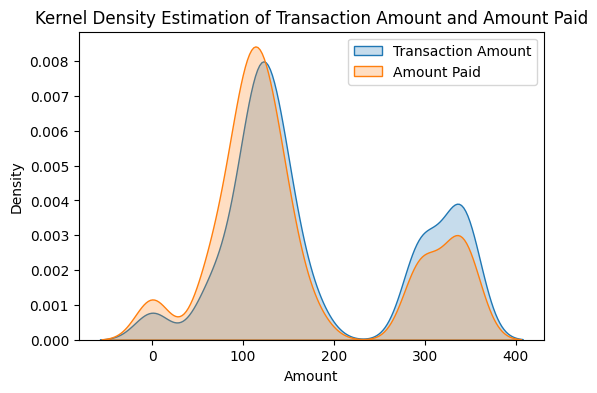

In [237]:

plt.figure(figsize=(6,4))
sns.kdeplot(data=df['Transaction_Amount'], fill=True, label='Transaction Amount')
sns.kdeplot(data=df['Amount_paid'], fill=True, label='Amount Paid')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of Transaction Amount and Amount Paid')
plt.legend()
plt.show()


# Fraud indicator plot by hour

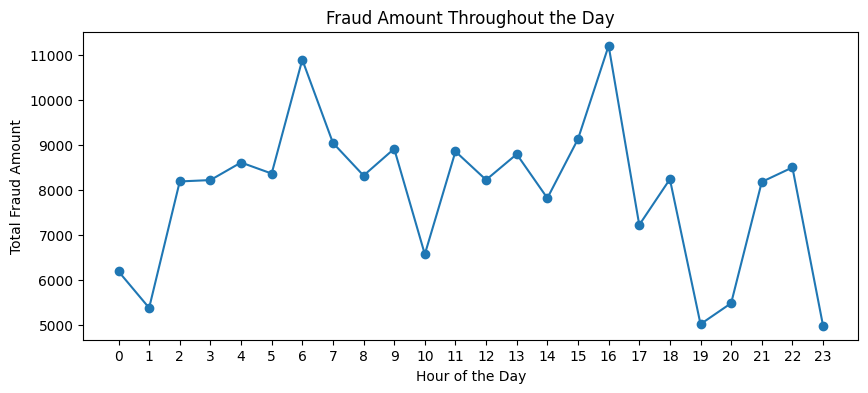

In [238]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract hour from the timestamp
df['Hour'] = df['Timestamp'].dt.hour

# Filter fraudulent transactions
fraudulent_transactions = df[df['Fraud_indicator'] == 'Fraud']

# Group by hour and sum transaction amount
fraudulent_amount_by_hour = fraudulent_transactions.groupby('Hour')['Transaction_Amount'].sum()

plt.figure(figsize=(10, 4))
fraudulent_amount_by_hour.plot(marker='o', linestyle='-')
plt.title('Fraud Amount Throughout the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Fraud Amount')
plt.xticks(range(24))
plt.show()

Interpretation:



1.   Fraudulent activity peaks around 6 AM, possibly due to the start of the day or commuting hours.

2.   Another peak is observed around 4 PM, likely linked to the end of the workday or rush hour traffic.



# **Feature Engineering**

# Extract features from the time stamp

In [239]:
df['Day']=df['Timestamp'].dt.dayofweek

df['Month']=df['Timestamp'].dt.month

In [240]:
df.iloc[:, -3:].head(3)

,Hour,Day,Month
0,11,4,1
1,14,5,1
3,2,0,1


# Transaction Behavior Features

In [241]:


# Calculate the difference between "Transaction_Amount" and "Amount_paid"
df['Amount_Difference'] = df['Transaction_Amount'] - df['Amount_paid']

# Calculate the ratio of "Amount_paid" to "Transaction_Amount"
df['Payment_Ratio'] = df['Amount_paid'] / df['Transaction_Amount']



In [242]:
df.iloc[:, -2:].head(3)

,Amount_Difference,Payment_Ratio
0,230,0.342857
1,20,0.833333
3,230,0.342857


# Encoding categorical features

In [243]:
df = pd.get_dummies(df, columns=['Vehicle_Type', 'Lane_Type', 'Vehicle_Dimensions'])


In [244]:
label_encoder = LabelEncoder()
df['Fraud_indicator'] = label_encoder.fit_transform(df['Fraud_indicator'])


In [245]:
df.head(3)

,Transaction_ID,Timestamp,FastagID,TollBoothID,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator,...,Vehicle_Type_Motorcycle,Vehicle_Type_SUV,Vehicle_Type_Sedan,Vehicle_Type_Truck,Vehicle_Type_Van,Lane_Type_Express,Lane_Type_Regular,Vehicle_Dimensions_Large,Vehicle_Dimensions_Medium,Vehicle_Dimensions_Small
0,1,2023-01-06 11:20:00,FTG-001-ABC-121,A-101,350,120,"13.059816123454882, 77.77068662374292",65,KA11AB1234,0,...,0,0,0,0,0,1,0,1,0,0
1,2,2023-01-07 14:55:00,FTG-002-XYZ-451,B-102,120,100,"13.059816123454882, 77.77068662374292",78,KA66CD5678,0,...,0,0,0,0,0,0,1,0,0,1
3,4,2023-01-09 02:05:00,FTG-044-LMN-322,C-103,350,120,"13.059816123454882, 77.77068662374292",92,KA11GH3456,0,...,0,0,0,1,0,0,1,1,0,0


In [246]:
# Extract latitude and longitude from 'Geographical_Location'
df['Latitude'] = df['Geographical_Location'].apply(lambda x: float(x.split(',')[0]))
df['Longitude'] = df['Geographical_Location'].apply(lambda x: float(x.split(',')[1]))

# Drop the original 'Geographical_Location' column
df.drop(columns=['Geographical_Location'], inplace=True)


In [247]:
df.head(2)

,Transaction_ID,Timestamp,FastagID,TollBoothID,Transaction_Amount,Amount_paid,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator,Hour,...,Vehicle_Type_Sedan,Vehicle_Type_Truck,Vehicle_Type_Van,Lane_Type_Express,Lane_Type_Regular,Vehicle_Dimensions_Large,Vehicle_Dimensions_Medium,Vehicle_Dimensions_Small,Latitude,Longitude
0,1,2023-01-06 11:20:00,FTG-001-ABC-121,A-101,350,120,65,KA11AB1234,0,11,...,0,0,0,1,0,1,0,0,13.059816,77.770687
1,2,2023-01-07 14:55:00,FTG-002-XYZ-451,B-102,120,100,78,KA66CD5678,0,14,...,0,0,0,0,1,0,0,1,13.059816,77.770687


# Feature importance

In [248]:


# Separate features and target variable
X = df.drop(columns=['Fraud_indicator', 'Timestamp', 'FastagID', 'TollBoothID','Transaction_ID','Vehicle_Plate_Number'])
y = df['Fraud_indicator']

imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the features and transform the features
X_imputed = imputer.fit_transform(X)

rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_imputed, y)

feature_importances = rf_classifier.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top 5 important features
top_n = 5
print(f"Top {top_n} Important Features:")
print(feature_importance_df.head(top_n))


Top 5 Important Features:
                     Feature  Importance
6          Amount_Difference    0.446373
7              Payment_Ratio    0.375936
1                Amount_paid    0.105121
0         Transaction_Amount    0.026841
19  Vehicle_Dimensions_Small    0.013325


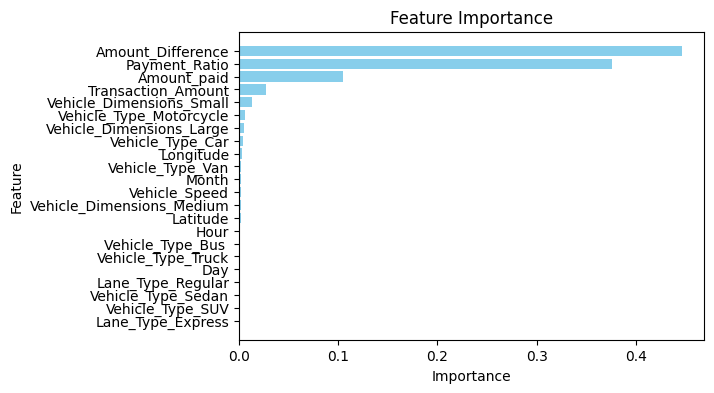

In [249]:
plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Model development

Logistic regression

In [250]:
top_features = feature_importance_df.head(5)['Feature'].tolist()
X_top_features = X[top_features]
y = df['Fraud_indicator']

# StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logistic_model = LogisticRegression()

# Initialize lists to store evaluation metrics
accuracies = []

# Perform cross-validation
for train_index, test_index in skf.split(X_top_features, y):
    X_train, X_test = X_top_features.iloc[train_index], X_top_features.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Fit the model
    logistic_model.fit(X_train_imputed, y_train)

    # Make predictions
    y_pred = logistic_model.predict(X_test_imputed)

    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracies)
print("Mean Accuracy of stratified cross validation:", mean_accuracy)

# Display classification report using the entire dataset
X_imputed = imputer.fit_transform(X_top_features)
logistic_model.fit(X_imputed, y)
y_pred = logistic_model.predict(X_imputed)
print("Classification Report:")
print(classification_report(y, y_pred))

Mean Accuracy of stratified cross validation: 0.9836002976077882
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       983
           1       0.98      1.00      0.99      3468

    accuracy                           0.98      4451
   macro avg       0.99      0.96      0.98      4451
weighted avg       0.98      0.98      0.98      4451



# AUC curve

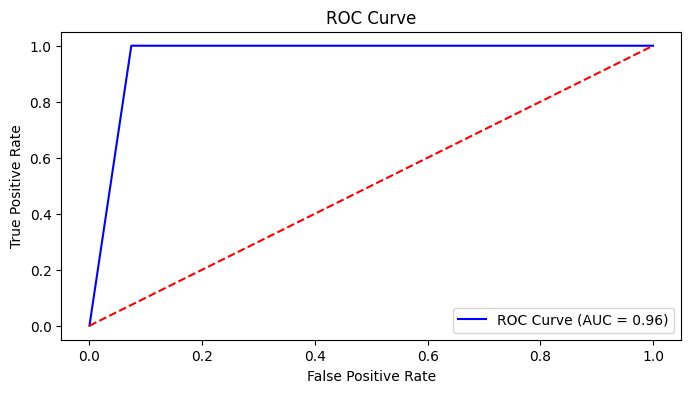

In [251]:

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion matrix

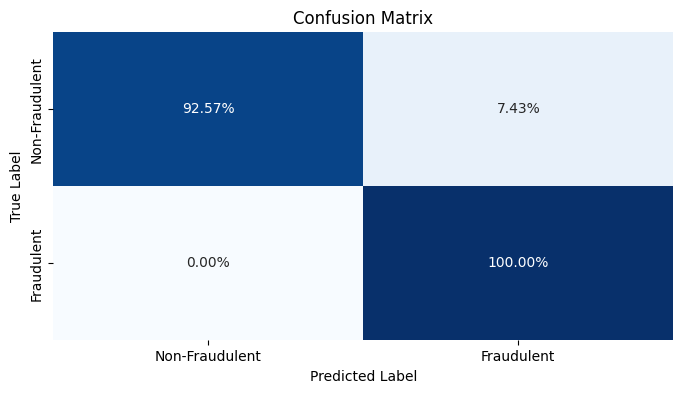

In [252]:


# Calculate confusion matrix
cm = confusion_matrix(y, y_pred)

# Normalize confusion matrix
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize along the true labels (rows)

# Define class labels
class_labels = ['Non-Fraudulent', 'Fraudulent']

# Plot confusion matrix with probabilities
plt.figure(figsize=(8, 4))
sns.heatmap(cm_norm, annot=True, cmap='Blues', fmt='.2%', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# **Real-time Fraud Detection feasability**

### Real-time Fraud Detection Implementation

1. **Data Streaming**:
   - Data streaming is crucial for processing Fastag transactions in real-time. Technologies like Apache Kafka or Amazon Kinesis are commonly used for this purpose.
   - To set up a data streaming pipeline with Apache Kafka, follow these steps:
     1. Install and configure Apache Kafka on your infrastructure.
     2. Create Kafka topics for ingesting Fastag transaction data.
     3. Develop producers to publish Fastag transaction data to Kafka topics.
     4. Set up consumers to process the streaming data and perform real-time analysis.

2. **Preprocessing**:
   - Preprocessing steps are required for real-time fraud detection:
     1. Feature engineering: Extract relevant features from the transaction data.
     2. Encoding: Convert categorical features into numerical representations.
     3. Scaling: Scale numerical features to a similar range.


3. **Model Inference**:
   - Trained fraud detection models need to be deployed to a production environment for real-time inference.
   - Deploy the model using AWS Lambda and set up API Gateway to trigger the Lambda function for processing incoming Fastag transactions.

4. **Thresholds and Alerts**:
   - Define thresholds for fraud probability or anomaly scores generated by the model.
   - Trigger alerts or flag transactions when their scores exceed certain thresholds, ensuring timely detection and response to potential fraud.

5. **Integration with Fastag Systems**:
   - Integrate the real-time fraud detection system with existing Fastag systems or payment gateways to ensure seamless operation.
   - Set up communication channels for exchanging data between systems and implement protocols for handling flagged transactions within the Fastag ecosystem.

6. **Monitoring and Feedback Loop**:
   - Continuous monitoring of the real-time fraud detection system is essential to ensure its effectiveness.
   - Collect feedback on flagged transactions and model predictions to iteratively improve the model, enhancing its accuracy and reliability over time.

7. **Scalability and Resilience**:
   - Ensure that the real-time fraud detection system is designed to handle varying loads of incoming transactions and is resilient to failures or disruptions.
   - Implement auto-scaling mechanisms, fault tolerance strategies, and performance optimizations to maintain system reliability and responsiveness.

8. **Compliance and Regulations**:
   - Adhere to relevant compliance requirements and regulations governing fraud detection and data privacy.
   - Implement data protection measures and privacy controls to safeguard sensitive information and ensure compliance with standards such as GDPR, PCI DSS, or local financial regulations.
